## Module

In [1]:
import os
import os.path as pth
import cv2
import time
import shutil
import random
import collections
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Concatenate

from tqdm.auto import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

## Device

In [2]:
print(tf.__version__)
print(device_lib.list_local_devices())

2.4.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14430626066608271576
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10563764864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17101329034301221106
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:3f:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10563764864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11552492275470710769
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:40:00.0, compute capability: 7.5"
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 10563764864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7276382323768240183
physical_device_desc: "device: 2, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5"
, name: "/device:GPU:3"
device_type: "GPU"
memory_limit: 10563764864
locality {
  bus_id: 1
  links {
  }
}
incarnation:

### Multi Device

In [3]:
#tf.compat.v1.disable_eager_execution()
mirrored_strategy = tf.distribute.MirroredStrategy()
#mirrored_strategy = tf.distribute.MirroredStrategy(devices = ["/gpu:4", "/gpu:5", "/gpu:6", "/gpu:7"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


## Constant

In [4]:
PATH = '../molecular_data/'
TRAIN_DIR = PATH + 'train'
TEST_DIR = PATH + 'test'

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

class CFG : 
    debug = False
    size = 300
    data_ut = 2424186 #500000
    seed = 42
    batch_size = 512
    buffer_size = 1000
    learning_rate = 5 * 1e-4
    base_channel = 8
    model_encoder_name = 'CustomDenseNet-121'
    model_base_path = pth.join('model', 'checkpoint')

In [5]:
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

## Label Load

In [6]:
#train = pd.read_pickle('train2.pkl')
train = pd.read_csv(PATH + 'train_labels.csv')
train.head()

,image_id,InChI
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...


### Add path

In [7]:
def get_path(img_name) : 
    return f"{TRAIN_DIR}/{img_name[0]}/{img_name[1]}/{img_name[2]}/{img_name}.png"

train['path'] = train['image_id'].apply(get_path)

In [8]:
train.head()

,image_id,InChI,path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,../molecular_data/train/0/0/0/000011a64c74.png
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,../molecular_data/train/0/0/0/000019cc0cd2.png
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,../molecular_data/train/0/0/0/0000252b6d2b.png
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,../molecular_data/train/0/0/0/000026b49b7e.png
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,../molecular_data/train/0/0/0/000026fc6c36.png


In [9]:
len(train['InChI'].unique())

2424186

## Image Check

In [10]:
def visualize_train_image(image_pth, label):
    plt.figure(figsize=(10, 8))
    
    image = cv2.imread(image_pth)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"{label}", fontsize=14)
    plt.axis("off")
    
    plt.show()

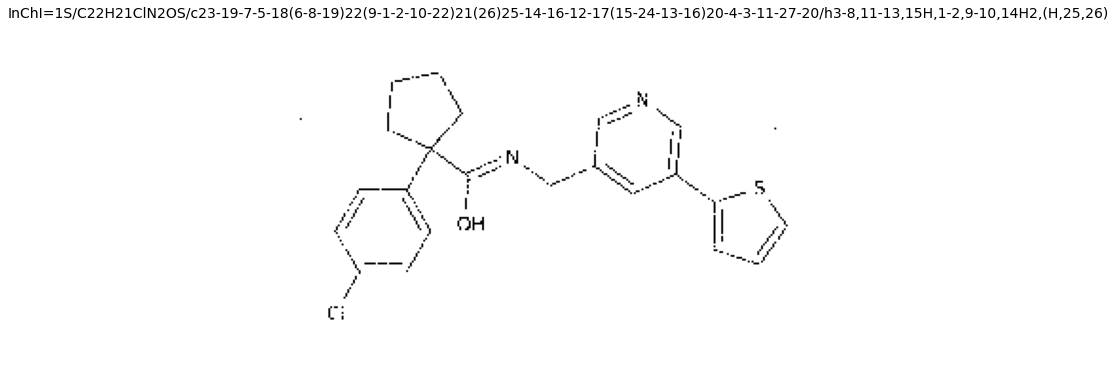

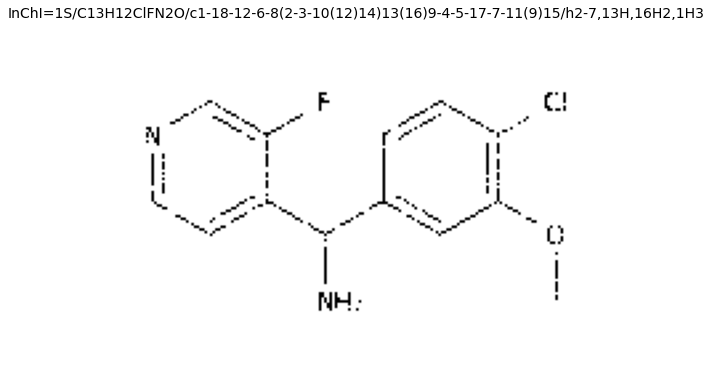

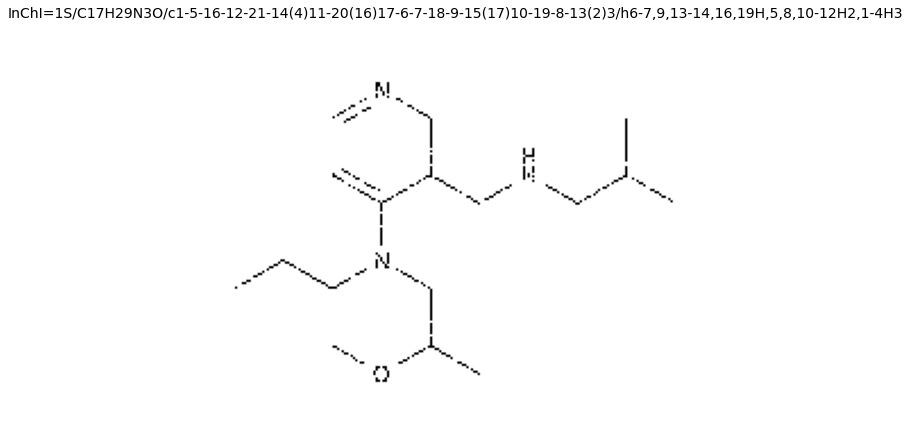

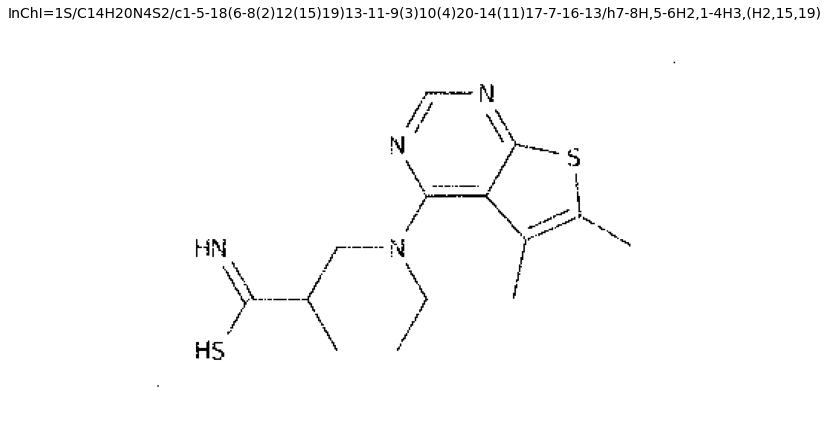

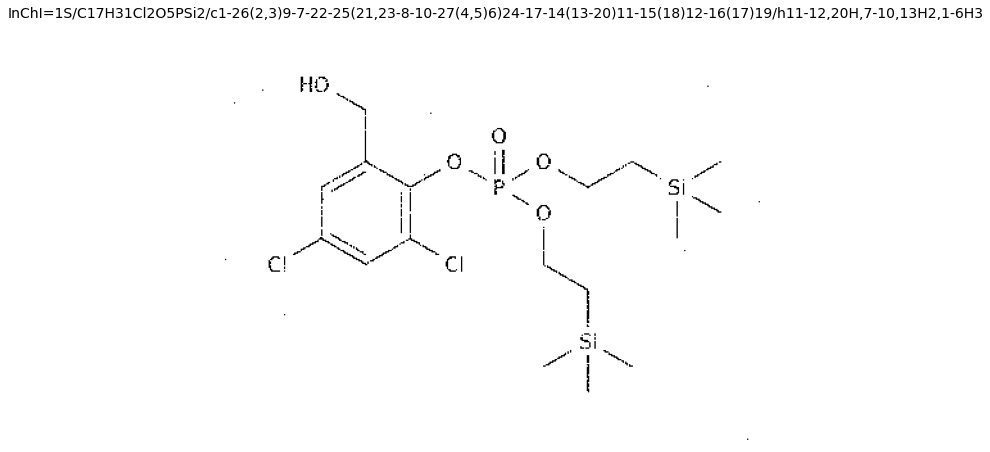

In [11]:
sample_row = train.sample(5)
for i in range(5) : 
    visualize_train_image(sample_row.iloc[i].path, sample_row.iloc[i].InChI)

## train vector

Caption sorting을 왜하는지 몰라서 제거

In [12]:
all_captions = []
all_img_name_vector = []

for idx in tqdm(train.index) : 
    caption = train['InChI'].iloc[idx]
    img_name = train['path'].iloc[idx]
    all_captions.append(caption)
    all_img_name_vector.append(img_name)

  0%|          | 0/2424186 [00:00<?, ?it/s]

### Shuffle and Cut

In [13]:
train_captions, train_img_name_vector = shuffle(all_captions, all_img_name_vector, random_state = CFG.seed)
train_captions = train_captions[:CFG.data_ut]
train_img_name_vector = train_img_name_vector[:CFG.data_ut]
print(len(train_captions))

2424186


InChI=1S/C21H22N6O4/c1-10-19-14(27-21(22)24-10)7-13(26-20(19)28)11-5-16(29-2)17(30-3)6-12(11)15-8-23-9-18(25-15)31-4/h5-6,8-9,13H,7H2,1-4H3,(H,26,28)(H2,22,24,27)/t13-/m1/s1


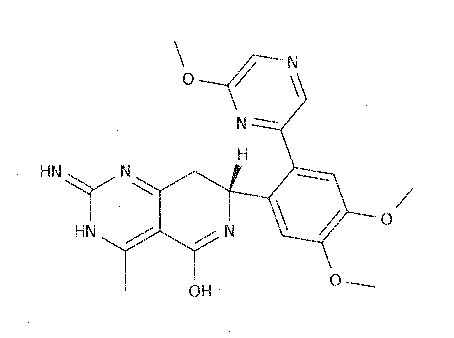

In [14]:
print(train_captions[0])
Image.open(train_img_name_vector[0])

## AutoEncoder

### Basic Setting

In [15]:
model_base_path = CFG.model_base_path
model_encoder_name = CFG.model_encoder_name
model_name = 'Autoencoder_{}_trts_basech_{:03d}'.format(model_encoder_name, CFG.base_channel)

### Data Split

In [16]:
img_name_train, img_name_val = train_test_split(train_img_name_vector, test_size = 0.2, random_state = CFG.seed)
len(img_name_train), len(img_name_val)

(1939348, 484838)

In [17]:
def map_func(img_path) : 
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels = 1)
    img = tf.dtypes.cast(img, tf.float32)
    img = img/255.0
    img = tf.image.resize(img, (CFG.size, CFG.size))
    return img, img

def prep_func(img) : 
    result_img = tf.keras.applications.inception_v3.preprocess_input(img)
    return result_img, result_img

### Dataset

납득이 안가는 test dataset 부분 제거

In [18]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train))
dataset_train = dataset_train.map(map_func, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.shuffle(CFG.buffer_size).batch(CFG.batch_size)
dataset_train = dataset_train.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [19]:
dataset_val = tf.data.Dataset.from_tensor_slices((img_name_val))
dataset_val = dataset_val.map(map_func, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset_val = dataset_val.batch(CFG.batch_size)
dataset_val = dataset_val.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

### Model

In [20]:
def Conv_Block(x, growth_rate, activation = 'relu'):
    x_l = BatchNormalization()(x)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate * 4, (1, 1), padding = 'same', kernel_initializer = 'he_normal')(x_l)
    
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate, (3, 3), padding = 'same', kernel_initializer = 'he_normal')(x_l)
    
    x = Concatenate()([x, x_l])
    
    return x

def Dense_Block(x, layers, growth_rate=32):
    for i in range(layers):
        x = Conv_Block(x, growth_rate)
    return x

def Transition_Layer(x, compression_factor = 0.5, activation = 'relu'):
    reduced_filters = int(K.int_shape(x)[-1] * compression_factor)
    
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(reduced_filters, (1, 1), padding = 'same', kernel_initializer = 'he_normal')(x)
    
    x = AveragePooling2D((2, 2), padding = 'same', strides = 2)(x)
    
    return x

layers_in_block = {'CustomDenseNet-121' : [6, 12, 24, 16],
                   'CustomDenseNet-169' : [6, 12, 32, 32],
                   'CustomDenseNet-201' : [6, 12, 48, 32],
                   'CustomDenseNet-265' : [6, 12, 64, 48]}

def DenseNet(model_input, base_growth_rate = 32, densenet_type = 'CustomDenseNet-121'):
    x = Conv2D(base_growth_rate * 2, (7, 7), padding = 'same', strides = 2, kernel_initializer = 'he_normal')(model_input) # (224, 224, 3) -> (112, 112, 64)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((3, 3), padding = 'same', strides = 2)(x) # (112, 112, 64) -> (56, 56, 64)
    
    x = Dense_Block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_Layer(x, compression_factor = 0.5)
    x = Dense_Block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_Layer(x, compression_factor = 0.5)
    x = Dense_Block(x, layers_in_block[densenet_type][2], base_growth_rate)
    x = Transition_Layer(x, compression_factor = 0.5)
    x = Dense_Block(x, layers_in_block[densenet_type][3], base_growth_rate)
    
    model = Model(model_input, x, name = densenet_type)
    
    return model

In [21]:
def build_model(base_channel = 32):
    input_layer = Input(shape = (CFG.size, CFG.size, 1))
    encoder = DenseNet(input_layer, base_growth_rate = base_channel, densenet_type = model_encoder_name)(input_layer)
    
    x = Conv2D(base_channel * 32, (3, 3), activation = 'relu', padding = 'same')(encoder)
    x = Conv2D(base_channel * 32, (3, 3), activation = 'relu', padding = 'same')(x)
    x = Conv2D(base_channel * 32, (3, 3), activation = 'relu', padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(base_channel * 16, (3, 3), activation = 'relu', padding = 'same')(x)
    x = Conv2D(base_channel * 16, (3, 3), activation = 'relu', padding = 'same')(x)
    x = Conv2D(base_channel * 16, (3, 3), activation = 'relu', padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(base_channel * 8, (3, 3), activation = 'relu', padding = 'valid')(x)
    x = Conv2D(base_channel * 8, (3, 3), activation = 'relu', padding = 'same')(x)
    x = Conv2D(base_channel * 8, (3, 3), activation = 'relu', padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(base_channel * 4, (3, 3), activation = 'relu', padding = 'same')(x)
    x = Conv2D(base_channel * 4, (3, 3), activation = 'relu', padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(base_channel * 2, (3, 3), activation = 'relu', padding = 'valid')(x)
    x = Conv2D(base_channel * 2, (3, 3), activation = 'relu', padding = 'same')(x)
    x = UpSampling2D((2, 2))(x)

    decoder = Conv2D(1, (3, 3), activation = 'linear', padding = 'same')(x)
    model = Model(inputs = input_layer, outputs = decoder)
    return model

In [22]:
#model = build_model(base_channel = CFG.base_channel)
#model.summary()

In [23]:
model_path = pth.join(CFG.model_base_path, model_name)

if pth.isdir(model_path):
    shutil.rmtree(model_path)
    
os.makedirs(model_path, exist_ok = True)

model_filename = pth.join(model_path, '{epoch:06d}-{loss:.6f}-{val_loss:.6f}.hdf5')
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_filename, verbose = 1, 
                       period = 1, save_best_only = True, 
                       monitor = 'val_loss')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

with mirrored_strategy.scope() :
    model = build_model(base_channel = CFG.base_channel)
    model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = CFG.learning_rate),
                  metrics = ['mse', 'mae'])
#model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = CFG.learning_rate),
#              metrics = ['mse', 'mae'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [25]:
! ls {model_path}
print('path :', model_path)
latest = tf.train.latest_checkpoint(model_path)
print('latest :', latest)
model.load_weights('model/checkpoint/001633.hdf5')

path : model/checkpoint/Autoencoder_CustomDenseNet-121_trts_basech_008
latest : None


In [ ]:
hist = model.fit(
    x = dataset_train, epochs = 30, 
    validation_data = dataset_val, shuffle = True,
    callbacks = [checkpointer, early_stopping], 
    #batch_size = CFG.batch_size
)

In [ ]:
#t_model = tf.keras.models.load_model('model/checkpoint/001684.hdf5')

(1, 300, 300, 1)


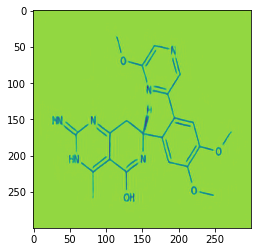

In [26]:
testing1, testing2 = map_func(train_img_name_vector[0])
testing = tf.expand_dims(testing1, 0)
img_testing = model.predict(testing, steps = 1)
print(img_testing.shape)
result_img = img_testing[0]
plt.imshow(result_img)